# Simple Genetic Algorithm
## Vinicius Pimenta Bernardo (202002447)

In [48]:
# Import libraries and helper functions

import random
import math
import struct
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt

L = 4 * 8  # size of chromosome in bits

def floatToBits(f):
    s = struct.pack('>f', f)
    return struct.unpack('>L', s)[0]


def bitsToFloat(b):
    s = struct.pack('>L', b)
    return struct.unpack('>f', s)[0]


def getBits(x):
    x = floatToBits(x)
    bits = []
    for bit in range(L):
        b = x & (2**bit)
        if b > 0:
            bits.append(1)
        else:
            bits.append(0)
    return bits


def getFloat(bits):
    x = 0
    for i, bit in enumerate(bits):
        x += bit * (2**i)
    return bitsToFloat(x)

In [50]:
Chromosome = List[int]
Population = List[Chromosome]

def generateChromosome() -> Chromosome:
    """
    Generate a chromosome inside domain
    @return: List of 32 integer values of either 1 or 0
    """
    return getBits(random.uniform(0, math.pi))


def randomPopulation(size: int = 20) -> Population:
    """
    Generate a List of Chromosomes 
    @param size: size of the population
    @return: List of random chromosomes inside domain
    """
    return [generateChromosome() for _ in range(size)]


def fitnessFunc(x: Chromosome) -> float:
    """
    Gives the fitness of a chromosome
    @param x: x as List[int]
    return: zero when out of domain otherwise f(x)
    """
    x_as_float = getFloat(x)
    if x_as_float <= math.pi and x_as_float >= 0 and math.isfinite(x_as_float):
        return x_as_float + abs(math.sin(32*x_as_float))
    else:
        return 0


def selectionPair(population: Population) -> Population:
    """Select a parent couple
    Return a tuple of chromosomes taking their fitness as weight
    @param population:
    """
    return random.choices(
        population=population,
        weights=[fitnessFunc(chromosome) for chromosome in population],
        k=2
    )


def singlePointCrossover(a: Chromosome, b: Chromosome, probability: float = 0.5) -> Tuple[Chromosome, Chromosome]:
    """
    Implementation of single point crossover of chromosome limiting output to domain (0 to pi)
    @param a: first parent chromosome
    @param b: second parent chromosome
    @param probability: chance that the crossover will occur
    @return: the descendents of the parents chromosomes
    """
    if len(a) != len(b):
        raise ValueError("Chromosomes a and b must be of same lenght")
    
    offspring_a = a
    offspring_b = b

    if (random.random() > probability) or (len(a) < 2):
        return offspring_a, offspring_b
    else:
        p = random.randint(1, len(a)-1)
        candidate_a = a[0:p] + b[p:]
        candidate_b = b[0:p] + a[p:]

        # only accept offsprings that are inside the domain
        if getFloat(candidate_a) >= 0 and getFloat(candidate_a) <= math.pi and math.isfinite(getFloat(candidate_a)):
            offspring_a = candidate_a
        elif getFloat(candidate_a) > math.pi or math.isinf(getFloat(candidate_a)):
            offspring_a = getBits(math.pi)
        elif getFloat(candidate_a) < 0 or math.isnan(getFloat(candidate_a)):
            offspring_a = getBits(0)

        if getFloat(candidate_a) >= 0 and getFloat(candidate_a) <= math.pi and math.isfinite(getFloat(candidate_a)):
            offspring_b = candidate_b
        elif getFloat(candidate_b) > math.pi or math.isinf(getFloat(candidate_b)):
            offspring_b = getBits(math.pi)
        elif getFloat(candidate_b) < 0 or math.isnan(getFloat(candidate_b)):
            offspring_b = getBits(0)
        
        return offspring_a, offspring_b
            


def mutationFunc(chromosome: Chromosome, num: int = 1, probability: float = 0.5) -> Chromosome:
    """Do a bit flip
    Randomly mutates a single bit from the chromosome and limit the output to the domain (0 to pi)
    @param chromosome: the input to be mutated
    @param num: amount of mutations
    @param probability: chance that each mutation occur
    @return: the mutated chromosome
    """
    mutated = chromosome
    for _ in range(num):
        index = random.randrange(len(mutated)-1)
        mutated[index] = mutated[index] if random.random() > probability else abs(mutated[index] - 1)
    
    # adjust to domain after mutation
    if getFloat(mutated) >= 0 and getFloat(mutated) <= math.pi and math.isfinite(getFloat(mutated)):
        return mutated
    elif getFloat(mutated) > math.pi or math.isinf(getFloat(mutated)):
        return getBits(math.pi)
    elif getFloat(mutated) < 0 or math.isnan(getFloat(mutated)):
        return getBits(0)
    else:
        return chromosome

In [51]:
def run_evolution(population_size: int = 20, generation_limit: int = 100, crossover_prob: float = 0.5, mutation_prob: float = 0.5, mutation_num: int = 1, gen_to_sample_one: int = 1, gen_to_sample_two: int = 10, gen_to_sample_three: int = 100):
    """Run the evolution
    @param population_size: defaults to 20
    @param generation_limit: number of generations (defaults to 100)
    @param crossover_prob: probability that a crossover occur (between 0 and 1)
    @param mutation_prob: probability that a single bit flip occur (between 0 and 1)
    @param mutation_num: number of mutations per child per generation
    @param gen_sample_one: choose first generation to sample (defaults to 1)
    @param gen_sample_two: choose first generation to sample (defaults to 10)
    @param gen_sample_three: choose first generation to sample (defaults to 100)
    @return: last generation, list of mean fitness of every generation, 3x list of tuples of x and f(x) of sampled generations
    """
    population = randomPopulation(population_size)

    mean_fit = []
    gen_fit_sample_one = []
    gen_fit_sample_two = []
    gen_fit_sample_three = []

    # main loop
    for i in range(1, generation_limit + 1):
        # sort population
        population = sorted(
            population, key=lambda x: fitnessFunc(x), reverse=True)
        
        # saves especific generation data for plots
        if i == gen_to_sample_one:
            gen_fit_sample_one = [(getFloat(population[x]), fitnessFunc(population[x])) for x in range(len(population))]
        elif i == gen_to_sample_two:
            gen_fit_sample_two = [(getFloat(population[x]), fitnessFunc(population[x])) for x in range(len(population))]
        elif i == gen_to_sample_three:
            gen_fit_sample_three = [(getFloat(population[x]), fitnessFunc(population[x])) for x in range(len(population))]

        # get mean fitness of every generation for plot
        mf = 0
        for m in range(len(population)):
            mf += (fitnessFunc(population[m]) / len(population))
        mean_fit.append(mf)
        if i % 10 == 0:
            print(f"Generation {i} .. mean fitness: {mf} .. fittest chromosome: {getFloat(population[0])}\n")
        

        next_generation = []

        # next generation creation loop (secondary loop)
        for _ in range(int(len(population) / 2)):
            parents = selectionPair(population)
            offspring_a, offspring_b = singlePointCrossover(a=parents[0], b=parents[1], probability=crossover_prob)
            offspring_a = mutationFunc(offspring_a, num=mutation_num, probability=mutation_prob)
            offspring_b = mutationFunc(offspring_b, num=mutation_num, probability=mutation_prob)
            next_generation += [offspring_a, offspring_b]

        population = next_generation

    # sort population one last time
    population = sorted(
        population, key=lambda x: fitnessFunc(x), reverse=True)
    return population, mean_fit, gen_fit_sample_one, gen_fit_sample_two, gen_fit_sample_three

In [68]:
# Do not change other than function input values
pop, y_axis, f, t, h = run_evolution(population_size=20, generation_limit=600, crossover_prob=0.2, mutation_prob=0.1, gen_to_sample_one = 1, gen_to_sample_two = 50, gen_to_sample_three = 600)

Generation 10 .. mean fitness: 3.7865586050698012 .. fittest chromosome: 3.008881092071533

Generation 20 .. mean fitness: 3.4116847292999593 .. fittest chromosome: 3.008881092071533

Generation 30 .. mean fitness: 3.700933495497708 .. fittest chromosome: 3.009125232696533

Generation 40 .. mean fitness: 3.837336526903808 .. fittest chromosome: 3.008270740509033

Generation 50 .. mean fitness: 3.771195333847409 .. fittest chromosome: 3.01116943359375

Generation 60 .. mean fitness: 3.3545560157535093 .. fittest chromosome: 3.012054920196533

Generation 70 .. mean fitness: 3.7175565170085676 .. fittest chromosome: 3.011078357696533

Generation 80 .. mean fitness: 3.799950991256262 .. fittest chromosome: 3.011077880859375

Generation 90 .. mean fitness: 3.4381437311506193 .. fittest chromosome: 3.0091254711151123

Generation 100 .. mean fitness: 3.317941109905611 .. fittest chromosome: 3.001438617706299

Generation 110 .. mean fitness: 3.84468466525048 .. fittest chromosome: 3.0032505989

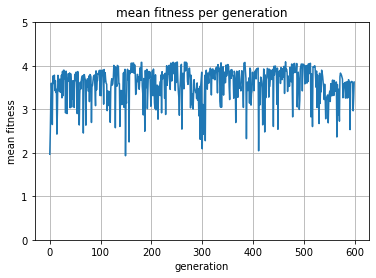

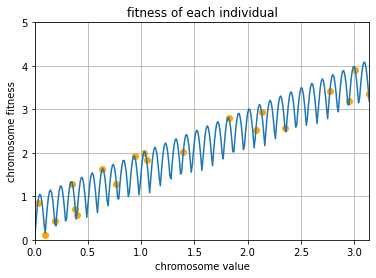

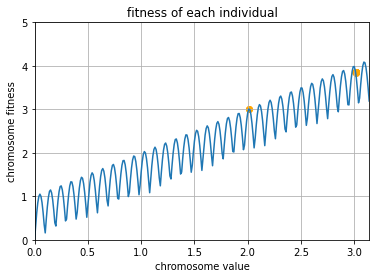

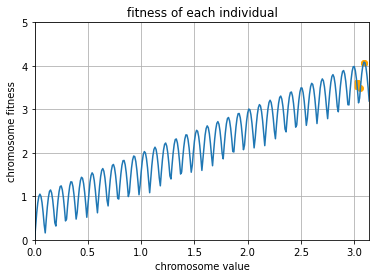

In [75]:
# Plots
# Mean fitness of every generation
fig, ax = plt.subplots()
ax.plot(range(len(y_axis)), y_axis)
plt.ylim([0, 5])

ax.set(xlabel='generation', ylabel='mean fitness',
       title='mean fitness per generation')
ax.grid()
plt.show()

# Fitness function for next three plots
x = np.arange(0.0, math.pi, 0.01)
y = [(z + abs(math.sin(32*z))) for z in x]

# x and f(x) pair of first sampled generation as scatter plot
fig, ax = plt.subplots()
ax.plot(x, y)
ax.scatter([a[0] for a in f], [a[1] for a in f], color='orange')
plt.ylim([0, 5])
plt.xlim([0, math.pi])

ax.set(xlabel='chromosome value', ylabel='chromosome fitness',
       title='fitness of each individual of first sample')
ax.grid()
plt.show()

# x and f(x) pair of second sampled generation as scatter plot
fig, ax = plt.subplots()
ax.plot(x, y)
ax.scatter([a[0] for a in t], [a[1] for a in t], color='orange')
plt.ylim([0, 5])
plt.xlim([0, math.pi])

ax.set(xlabel='chromosome value', ylabel='chromosome fitness',
       title='fitness of each individual of second sample')
ax.grid()
plt.show()

# x and f(x) pair of third sampled generation as scatter plot
fig, ax = plt.subplots()
ax.plot(x, y)
ax.scatter([a[0] for a in h], [a[1] for a in h], color='orange')
plt.ylim([0, 5])
plt.xlim([0, math.pi])

ax.set(xlabel='chromosome value', ylabel='chromosome fitness',
       title='fitness of each individual of third sample')
ax.grid()
plt.show()